In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import chess_cv.utils as utils
from scipy.linalg import qr
%matplotlib inline

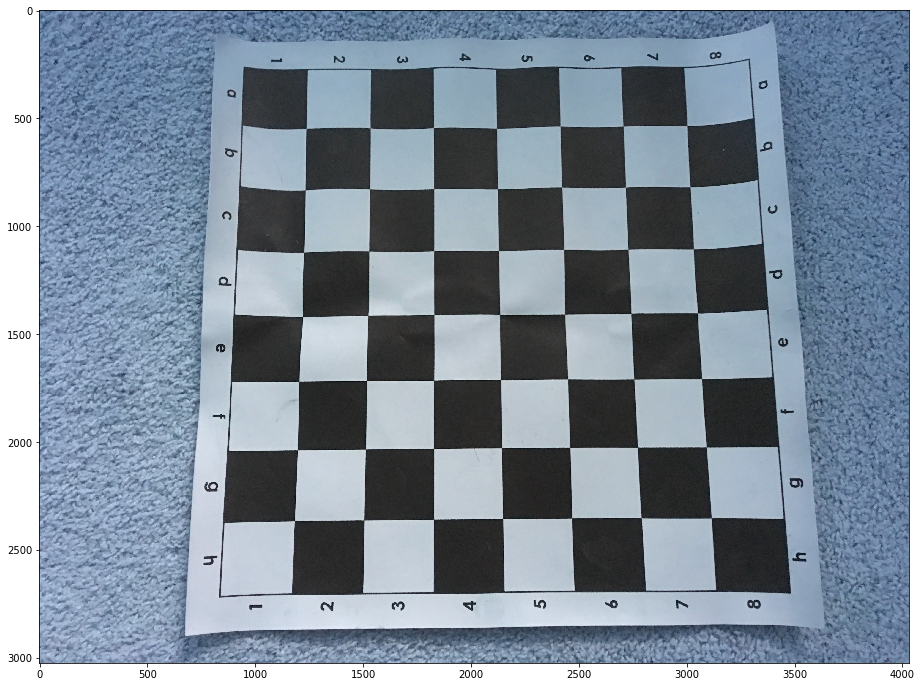

In [49]:
img_bgr = cv2.imread('data/IMG_0649.JPG') # works
#img_bgr = cv2.imread('data/IMG_0650.JPG') # works

#img_bgr = cv2.imread('data/IMG_0648.JPG') # works with sqrt y calc and bad line filtering
#img_bgr = cv2.imread('data/IMG_0651.JPG') # works with sqrt y calc and bad line filtering
utils.imshow_lg(plt, img_bgr)

In [50]:
gray = utils.bgr2gray(img_bgr)
rows, cols = gray.shape

gray = cv2.pyrDown(gray, dstsize=(cols//2, rows//2))
rows, cols = rows//2, cols//2
gray = cv2.pyrDown(gray, dstsize=(cols//2, rows//2))
rows, cols = rows//2, cols//2

def rect (img, pts, color=(0, 0, 255), size=5):
    first, last = pts[0], pts[0]
    for pt in pts[1:]:
        img = cv2.line(img, last,pt,color,size)
        last = pt
    return cv2.line(img,last,first,color,size)

In [106]:
def solve_minnonzero(A, b):
    x1, res, rnk, s = np.linalg.lstsq(A, b)
    if rnk == A.shape[1]:
        return x1   # nothing more to do if A is full-rank
    Q, R, P = qr(A.T, mode='full', pivoting=True)
    Z = Q[:, rnk:].conj()
    C = np.linalg.solve(Z[rnk:], -x1[rnk:])
    return x1 + Z.dot(C)

def find_saddle(img):
    m, n = img.shape
    bimg = cv2.GaussianBlur(img, (3,3), 1.5)
    X = np.zeros((m*n, 6))
    intensities = np.zeros((m*n, 1))
    i = 0
    for y in range(m):
        for x in range(n):
            X[i,:] = np.array([x**2, y**2, 2*x*y, y, x, 1])
            intensities[i] = bimg[y, x]
            i = i + 1
    
    Xt = X.transpose()
    theta = np.linalg.pinv(Xt @ X) @ Xt @ intensities
    
    A = np.array([theta[0], theta[2], theta[2], theta[1]]).reshape((2,2))
    b = np.array([theta[4], theta[3]]).reshape((2,1))
    
    w, v = np.linalg.eig(A)
    print(w)
    if np.any(np.isclose(w, np.zeros(w.shape), atol=1e-2)) or (w[0] < 0 and w[1] < 0) or (w[0] > 0 and w[1] > 0):
        return None
    return np.linalg.solve(2*A, -b)

[-0.03046441  0.06009787]
[[ 14.02448445]
 [ 13.49383393]]
[ 0.05049353 -0.00759037]
[-0.00562989  0.04719029]
[-0.04378896  0.03881402]
[[ 14.38888006]
 [ 12.86142928]]
[ 0.00676916 -0.00557785]
[ 0.03070184  0.02592954]
[-0.00084518  0.03343712]
[-0.0073654   0.03802364]
[ 0.01026683 -0.02101306]
[[ 23.10074596]
 [ 19.37504075]]
[-0.01360397  0.02185189]
[[ 27.48634374]
 [ 16.79638781]]
[-0.01424815  0.0030866 ]
[-0.01016686  0.01023837]
[-0.02029686  0.04264212]
[[ 12.44653803]
 [ 14.07336048]]
[ 0.03370525  0.00828138]
[ 0.01380576 -0.00416956]
[ 0.00666528 -0.03846698]
[-0.02837151 -0.00208876]
[ 0.03152817  0.0561069 ]
[ 0.02447701  0.00183662]
[-0.02233144  0.01197734]
[[  9.8158032 ]
 [ 11.49289893]]
[ 0.03436177 -0.02953515]
[[ 19.1548511 ]
 [ 17.16331564]]
[ 0.05865802 -0.05063588]
[[ 15.54459307]
 [ 17.36842909]]
[ 0.02225401  0.04427742]
[ 0.00646934 -0.05514032]
[-0.05699213 -0.01133726]
[-0.00412222  0.01528078]
[ 0.02101902 -0.01539356]
[[ 14.56101929]
 [  7.20130119]]
[

[ 0.0005973  -0.00353906]
[ 0.00331749 -0.00461175]
[-0.4128932  -0.00255253]
[-0.0118989   0.00843855]
[-0.06583914 -0.00127512]
[ 0.05282406  0.00402217]
[ 0.04792256 -0.00382313]
[-0.00601811  0.00515836]
[-0.01241595  0.01826488]
[[ 13.56248358]
 [  8.62540838]]
[ 0.01577478  0.02942905]
[-0.05576811  0.0021836 ]
[-0.03813098  0.00443315]
[ 0.01477919  0.00069435]
[ 0.01104966  0.06055653]
[-0.01492721 -0.02922204]
[-0.01675485  0.03996583]
[[  9.99433868]
 [ 15.77186711]]
[ 0.03780709 -0.0004324 ]
[-0.33723046 -0.04141182]
[ 0.00849997 -0.01901976]
[-0.00936736 -0.00582577]
[-0.41775221 -0.00376276]
[ 0.00535615  0.01249106]
[-0.45107575 -0.00202227]
[-0.00465454  0.00480451]
[  7.36615733e-03   6.38906042e-05]
[-0.42507355 -0.00233405]
[ 0.00256958 -0.00058953]
[-0.43320289 -0.00739265]
[ 0.0016277  0.0022286]
[-0.00312545  0.0031132 ]
[-0.40375953 -0.00160274]
[-0.00494095  0.00033182]
[-0.42257424 -0.00574526]
[ 0.00321591  0.01130667]
[ 0.01001227  0.00176951]
[-0.39622499  0.

[ 0.17269212 -0.0180009 ]
[[ 18.25873723]
 [ 15.5779679 ]]
[-0.0001855  -0.00112085]
[ 0.39391686 -0.00044561]
[ 0.00228034 -0.03870607]
[-0.00241108 -0.00122672]
[ 0.47925794  0.00225789]
[-0.00817069  0.00252503]
[ 0.40168412  0.00152381]
[-0.00378645  0.00071525]
[ 0.00019239 -0.00346338]
[ 0.03437811 -0.00974856]
[ 0.00517521  0.00683284]
[ 0.00065985  0.0044245 ]
[-0.25894569  0.00475403]
[-0.00098621  0.0004014 ]
[-0.42408085 -0.00760084]
[ 0.00462684 -0.00253407]
[ 0.00578416 -0.00532218]
[-0.03828444  0.08531984]
[-0.15509779  0.01208605]
[-0.01228055 -0.02848565]
[-0.02327833  0.02233515]
[[ 11.45491609]
 [ 15.46486744]]
[-0.07436269  0.02784258]
[[ 16.060345  ]
 [ 13.14228581]]
[-0.0263282 -0.0315054]
[-0.01903827  0.01073738]
[[ 3.33971054]
 [ 8.20796856]]
[ 0.03478843 -0.03225602]
[[ 20.85089992]
 [ 17.60144136]]
[-0.04126291  0.03378006]
[[ 15.32310426]
 [ 16.74210879]]
[ 0.02986281 -0.09927674]
[[ 12.5261766 ]
 [ 14.72615947]]
[-0.0284012   0.02813321]
[[ 15.84543305]
 [ 

[-0.00743261  0.01166251]
[ 0.00721483 -0.02085549]
[ 0.06348723 -0.3172088 ]
[[ 11.69204807]
 [ 15.31928142]]
[ 0.00483382 -0.25661357]
[-0.05931767 -0.34824364]
[ 0.00174896 -0.47595856]
[ 0.0027099  -0.38131327]
[ 0.01114557 -0.45678821]
[[ 27.61899998]
 [ 12.80313864]]
[-0.05242801 -0.46077945]
[ 0.00308573 -0.41327993]
[ 0.05213002 -0.54034129]
[[ 22.73340811]
 [ 12.90718725]]
[ 0.00504661 -0.41917094]
[ 0.00433484 -0.47312158]
[ 0.03669294 -0.58200288]
[[ 14.02420457]
 [ 11.14877931]]
[-0.01911282 -0.48632196]
[-0.003705   -0.47170915]
[-0.01005326 -0.55668971]
[ 0.00798699 -0.44043193]
[ 0.00384195 -0.44120357]
[-0.01605915 -0.34295417]
[ 0.00751992 -0.30566501]
[ 0.04581532 -0.47221933]
[[ 20.30808103]
 [ 11.36048888]]
[  2.46466213e-04  -3.43008265e-01]
[ 0.00444486 -0.18829348]
[ 0.05990069 -0.04011531]
[[ 24.0450063 ]
 [  9.06219185]]
[ 0.02240832 -0.00049243]
[-0.00867919  0.02248553]
[-0.00352924  0.07816094]
[ 0.00407544 -0.0225217 ]
[ 0.01993573  0.100598  ]
[-0.00752441

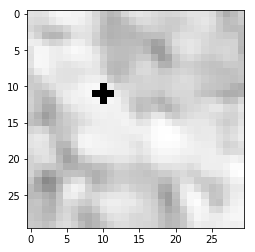

In [113]:
patch_size = 30
ps = patch_size # brevity
for i in range(rows//ps):
    for j in range(cols//ps):
        it, jt = i * ps, j * ps
        patch = gray[it:it+ps,jt:jt+ps]
        copy = np.copy(patch)
        pt = find_saddle(patch)
        if pt is None:
            continue
        pt = np.absolute(pt)
        if pt[0] > ps or pt[1] > ps:
            continue
        print(pt)
        copy = cv2.circle(copy, (int(pt[0]), int(pt[1])), 1, (0,255,0), -1)
        plt.imshow(copy, cmap='gray')